[<font color='steelblue'>1. - __EDA__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Exploratory Data Analysis</font>](#three-bullet) <br>

[<font color='steelblue'>2. - __Genetic Algorithms__</font>](#four-bullet) <br>
    [<font color='steelblue'>2.1. - Defining Classes and Functions</font>](#five-bullet) <br>
    [<font color='steelblue'>2.2. - Genetic Operators</font>](#six-bullet) <br>
    [<font color='steelblue'>2.3. - Genetic Algorithms</font>](#seven-bullet) <br>
    [<font color='steelblue'>2.4. - GridSearch</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.5. - Results</font>](#nine-bullet) <br>

[<font color='steelblue'>3. - __GA vs Other Optimization Techniques__</font>](#ten-bullet) <br>
    [<font color='steelblue'>3.1. - Hill Climbing</font>](#eleven-bullet) <br>
    [<font color='steelblue'>3.2. - Simulated Annealing</font>](#twelve-bullet) <br>

Group AU
|Name | Student ID |
|----|----|
|Joana Rodrigues| 20240603|
|Mara Simões| 20240326|
|Matilde Street| 20240523|
|Rafael Silva| 20240511|

<hr>
<a class="anchor" id="one-bullet">
<d style="color:white;">

# 1. EDA
</a>
</d>   

<a class="anchor" id="two-bullet">
<d style="color:white;">

## 1.1. Imports
</a>
</d>   

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

### 1.1.1. Import Libraries

In [39]:
from pathlib import Path
import pandas as pd
#from google.colab import drive
import numpy as np
import random
from copy import deepcopy
from typing import Callable
import math

### 1.1.2. Import Dataset

In [40]:
path = 'seating_data.xlsx'
df = pd.read_excel(path)
df= df.set_index('idx')

print(df.head())

#drive.mount('/content/drive')
#df = pd.read_csv("seating_data(in).csv", index_col=0)

       1     2     3     4    5    6    7    8    9    10  ...   55   56  57  \
idx                                                        ...                 
1       0  5000     0     0  700  700    0    0    0    0  ...  100  100   0   
2    5000     0   700   700    0    0  300  300  500  500  ...  100  100   0   
3       0   700     0  2000    0    0    0    0  300  300  ...    0    0   0   
4       0   700  2000     0    0    0  900  400  300  300  ...    0    0   0   
5     700     0     0     0    0    0    0    0    0    0  ...    0    0   0   

      58   59   60   61  62  63  64  
idx                                  
1      0  100  100  100   0   0   0  
2    100    0    0    0   0   0   0  
3      0    0    0    0   0   0   0  
4      0    0    0    0   0   0   0  
5      0    0    0    0   0   0   0  

[5 rows x 64 columns]


<a class="anchor" id="three-bullet">
<d style="color:white;">

## 1.2. Exploratory Data Analysis
</a>
</d>   

In [41]:
is_symmetric = (df == df.T).all().all()
print("Matrix is simetric?", is_symmetric)

Matrix is simetric? False


In [42]:
asymmetric_pairs = []
for i in df.index:
    for j in df.columns:
        if i != j and df.loc[i, j] != df.loc[j, i]:
            asymmetric_pairs.append((i, j, df.loc[i, j], df.loc[j, i]))

for a, b, val1, val2 in asymmetric_pairs:
    print(f"({a}, {b}) = {val1}")

(1, 54) = 1000
(2, 54) = 100
(54, 1) = 0
(54, 2) = 1000


It's said that 54 is the bride's best friend and not the groom's so we correct this mistake so that the matrix is simetric

In [43]:
df.at[1, 54] = df.at[54, 1] = 0
df.at[2, 54] = df.at[54, 2] = 1000

# Check if the matrix is symmetric after modification
asymmetric_pairs = []
for i in df.index:
    for j in df.columns:
        if i != j and df.loc[i, j] != df.loc[j, i]:
            asymmetric_pairs.append((i, j, df.loc[i, j], df.loc[j, i]))

for a, b, val1, val2 in asymmetric_pairs:
    print(f"({a}, {b}) = {val1}")

In [44]:
# 64 people in 8 tables with 8 seats each

total_combinations = math.factorial(64) // ((math.factorial(8) ** 8) * math.factorial(8))
print(f'The people invited to the wedding can be sat in {total_combinations} i.e. ({total_combinations:e}) different ways, as there are 8 tables each with 8 seats.')

The people invited to the wedding can be sat in 450538787986875167583433232345723106006796340625 i.e. (4.505388e+47) different ways, as there are 8 tables each with 8 seats.


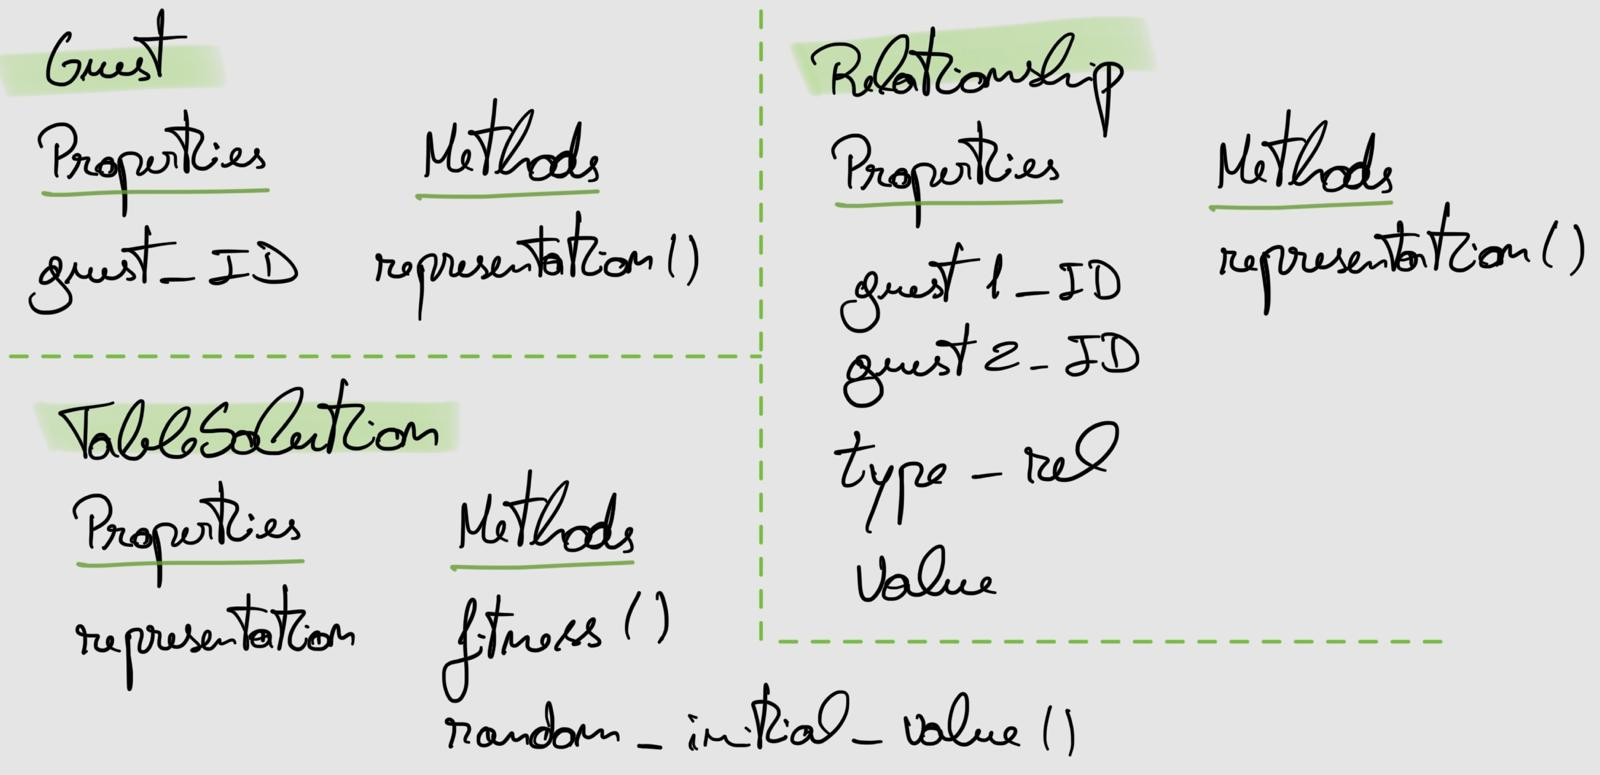

<hr>
<a class="anchor" id="four-bullet">
<d style="color:white;">

# 2. Genetic Algorithms
</a>
</d>   

<a class="anchor" id="five-bullet">
<d style="color:white;">

## 2.1. Defining Classes and Functions
</a>
</d>  

### 2.1.1. Guest class and Data Initialization

Before we can optimize who sits where at the wedding, we need to represent the guests and their relationships.

In [45]:
class Guest:
    def __init__(self, guest_id):
        self.guest_id = guest_id

    def __repr__(self):
        return f"{self.guest_id}"

relationship_matrix = df.to_numpy()
guest_ids = list(df.index)
guests = [Guest(guest_id) for guest_id in guest_ids]

### 2.1.2. Base Solution

This class is the base for all solutions with different variants (different selection algorithms, mutation and crossover).

In [105]:
class BaseGASolution:
    def __init__(self, num_tables=8, guests_per_table=8, guests=None, initialization_type='random'): # initial setup of a solution
        self.num_tables = num_tables
        self.guests_per_table = guests_per_table
        self.representation = [[] for _ in range(num_tables)]

        if guests:
            if initialization_type == "random":
                self.random_initial_value(guests)
            elif initialization_type == "sequential":
                self.sequential_initial_value(guests)
            elif initialization_type == "direct":
                pass  # do nothing; representation will be set manually
            else:
                raise ValueError("Initialization type must be 'random' or 'sequential'")

    def random_initial_value(self, guests): # randomly fills tables with guests
        shuffled = deepcopy(guests)
        random.shuffle(shuffled)
        for i, guest in enumerate(shuffled):
            self.representation[i % self.num_tables].append(guest)

    def sequential_initial_value(self, guests): # seats guests in fixed order
        for i, guest in enumerate(guests):
            table_idx = i // self.guests_per_table
            self.representation[table_idx].append(guest)

    def fitness(self): # calculates the fitness of the solution penalizing negative relationships
        score = 0
        for table in self.representation:
            for i in range(len(table)):
                for j in range(i + 1, len(table)):
                    g1 = guest_ids.index(table[i].guest_id)
                    g2 = guest_ids.index(table[j].guest_id)
                    relation = relationship_matrix[g1][g2]
                    if relation < 0:
                        score += 2 * relation # penalizes conflicts
                    else:
                        score += relation
        return score

    def repair(self, tables):
        """
        Ensures that all guests are present exactly once and evenly distributed across tables.

        This function:
        - Converts flat list to matrix if needed
        - Detects and replaces duplicate guests with missing ones
        - Adds any still missing guests if necessary
        - Ensures the final structure has the correct number of guests per table
        """

        # If input is flat, reshape into matrix
        if all(not isinstance(t, list) for t in tables):
            tables = [tables[i:i + self.guests_per_table] for i in range(0, len(tables), self.guests_per_table)]

        # Flatten the tables
        flat = [g for table in tables for g in table]
        guest_ids_in_flat = [g.guest_id for g in flat]
        all_ids = {g.guest_id for g in self.guests}

        # Count how many times each guest ID appears
        from collections import Counter
        counts = Counter(guest_ids_in_flat)

        # Identify missing and duplicated guest IDs
        missing_ids = list(all_ids - set(guest_ids_in_flat))
        duplicates = [gid for gid, c in counts.items() if c > 1]

        corrected = []
        seen_ids = set()
        for g in flat:
            if counts[g.guest_id] > 1 and g.guest_id in seen_ids and missing_ids:
                # Replace repeated guest with a missing one
                missing_id = missing_ids.pop()
                corrected.append(Guest(missing_id))
            else:
                corrected.append(g)
                seen_ids.add(g.guest_id)

        # Add any still-missing guests (e.g., if total < 64)
        present_ids = {g.guest_id for g in corrected}
        for mid in all_ids - present_ids:
            corrected.append(Guest(mid))

        # Trim and reshape into matrix of tables
        corrected = corrected[:self.num_tables * self.guests_per_table]
        return [corrected[i:i + self.guests_per_table] for i in range(0, len(corrected), self.guests_per_table)]

### 2.1.3. Functions

In [47]:
def restricted_mating_function(population, selection_algorithm, similarity_threshold_rm=2, max_attempts=100):
    for _ in range(max_attempts):
        p1 = selection_algorithm(population)
        p2 = selection_algorithm(population)
        if similarity(p1, p2) < similarity_threshold_rm:
            return deepcopy(p1), deepcopy(p2)
    # Fallback if no dissimilar pair found
    return deepcopy(p1), deepcopy(p2)

def similarity(ind1, ind2): #  calculates the similarity between two solutions
    count = 0
    for t1, t2 in zip(ind1.representation, ind2.representation):
        ids1 = set(g.guest_id for g in t1)
        ids2 = set(g.guest_id for g in t2)
        count += len(ids1 & ids2)
    return count

def get_best_ind(population: list): # returns the best individual in the population based on fitness
    fitness_list = [ind.fitness() for ind in population]
    return population[fitness_list.index(max(fitness_list))]

In [71]:
def validate_seating_solution(tables, expected_guests=64, expected_tables=8, guests_per_table=8):
    """
    Validates a seating solution.

    Checks:
    - Total number of guests is correct
    - No duplicate guest IDs
    - Each guest appears exactly once
    - Each table has the correct number of guests

    Parameters:
    - tables (list of list): A matrix where each inner list is a table of guests
    - expected_guests (int): Total number of unique guests expected (default: 64)
    - expected_tables (int): Total number of tables expected (default: 8)
    - guests_per_table (int): Number of guests per table (default: 8)

    Prints whether the solution is valid or invalid.
    """
    flat = [g.guest_id if hasattr(g, "guest_id") else g for table in tables for g in table]
    
    if len(flat) != expected_guests:
        print("Invalid: incorrect total number of guests.")
        return
    
    if len(set(flat)) != expected_guests:
        print("Invalid: duplicate guest IDs found.")
        return
    
    if len(tables) != expected_tables:
        print("Invalid: incorrect number of tables.")
        return

    if not all(len(table) == guests_per_table for table in tables):
        print("Invalid: at least one table does not have the correct number of guests.")
        return

    print("Valid seating solution")

### 2.1.4. Selection Algorithms

Fitness Proportionate Selection - Roulette Wheel

In [48]:
# with fitness sharing -> reduces the selection probability of similar individuals to encourage diversity in the population
def fitness_proportionate_selection(population: list, fitness_sharing: bool = False):
    if fitness_sharing:
        shared_fitness_values = []
        for i, ind_i in enumerate(population):
            raw_fitness = ind_i.fitness()
            sharing_sum = 0
            for j, ind_j in enumerate(population):
                if i != j:
                    sim = similarity(ind_i, ind_j)
                    sharing_sum += 1 / (1 + sim)
            adjusted_fitness = raw_fitness / (1 + sharing_sum)
            shared_fitness_values.append(adjusted_fitness)
        fitness_values = shared_fitness_values
    else:
        fitness_values = [ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0

    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

Rank Selection

In [49]:
# algotirhm not sensitive to differences in fitness
def rank_selection(population: list):
    sorted_population = sorted(population, key=lambda ind: ind.fitness())
    n = len(population)
    ranks = list(range(1, n + 1))  
    total_rank = sum(ranks)
    
    random_nr = random.uniform(0, total_rank)
    cumulative = 0

    for ind, rank in zip(sorted_population, ranks):
        cumulative += rank
        if random_nr <= cumulative:
            return deepcopy(ind)

Tournament Selection

In [50]:
def tournament_selection(population: list, k: int = 3): # k is tournament_size
    participants = random.sample(population, k)
    best = max(participants, key=lambda ind: ind.fitness())
    return deepcopy(best)

<a class="anchor" id="six-bullet">
<d style="color:white;">

## 2.2. Genetic Operators
</a>
</d>  

### 2.2.1. Crossover

In [51]:
def standard_crossover(parent1_repr, parent2_repr, n_tables=8):
    """
    One-point crossover that returns two valid offspring with no duplicates or missing guests.
    Offspring are returned in 8x8 format, and all guest IDs are preserved exactly once.
    """
    # Flatten parents
    parent1_flat = [guest for table in parent1_repr for guest in table]
    parent2_flat = [guest for table in parent2_repr for guest in table]

    total_guests = len(parent1_flat)
    guests_per_table = total_guests // n_tables

    # Define crossover point
    xo_point = random.randint(1, total_guests - 1)

    # First part from parent1, rest filled from parent2 in order (excluding duplicates)
    def build_child(p1_head, p2_tail):
        p1_ids = set(g.guest_id for g in p1_head)
        tail_filtered = [g for g in p2_tail if g.guest_id not in p1_ids]
        full = p1_head + tail_filtered
        return [full[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]

    child1 = build_child(parent1_flat[:xo_point], parent2_flat)
    child2 = build_child(parent2_flat[:xo_point], parent1_flat)

    return child1, child2

In [110]:
def cycle_crossover(parent1_repr, parent2_repr, n_tables=8):
    """
    Performs Cycle Crossover (CX) between two parents with matrix representation.

    Cycle Crossover preserves the position of elements by identifying a cycle
    of indices where the values from each parent will be inherited by each offspring.
    Parents are flattened, crossover is applied, and offspring are reshaped into matrices.

    Args:
        parent1 (list of lists): The first parent, representing a seating arrangement.
        parent2 (list of lists): The second parent, same format as parent1.
            Both parents must have the same length and type.
        n_tables (int, optional): Number of tables in the solution. Default is 8.

    Returns
        tuple: Two offspring seating arrangements as matrices.
    """
    # Flatten and extract guest IDs
    parent1_flat = [guest for table in parent1_repr for guest in table]
    parent2_flat = [guest for table in parent2_repr for guest in table]
    parent1_ids = [g.guest_id for g in parent1_flat]
    parent2_ids = [g.guest_id for g in parent2_flat]

    if len(parent1_ids) != len(parent2_ids):
        raise ValueError("Parents must be the same length")

    length = len(parent1_ids)
    child1_ids = [None] * length
    child2_ids = [None] * length
    visited = [False] * length

    start_idx = random.randint(0, length - 1)
    idx = start_idx
    cycle = []

    while not visited[idx]:
        cycle.append(idx)
        visited[idx] = True
        target_id = parent2_ids[idx]
        idx = parent1_ids.index(target_id)

    for i in range(length):
        if i in cycle:
            child1_ids[i] = parent1_ids[i]
            child2_ids[i] = parent2_ids[i]
        else:
            child1_ids[i] = parent2_ids[i]
            child2_ids[i] = parent1_ids[i]

    # Convert guest IDs back to Guest objects
    child1 = [Guest(gid) for gid in child1_ids]
    child2 = [Guest(gid) for gid in child2_ids]

    # Reshape back into table format
    table_size = length // n_tables
    offspring1_matrix = [child1[i:i + table_size] for i in range(0, length, table_size)]
    offspring2_matrix = [child2[i:i + table_size] for i in range(0, length, table_size)]

    return offspring1_matrix, offspring2_matrix

In [53]:
def table_block_crossover(parent1_repr, parent2_repr, n_tables=8):
    """
    Table Block Crossover: selects a random block of tables from each parent
    and fills the remaining guests from the other parent, preserving order and avoiding duplicates.

    Returns two valid offspring in 8x8 format (list of lists).
    """
    guests_per_table = len(parent1_repr[0])
    total_guests = n_tables * guests_per_table

    # Select a random block of table indices
    block_size = random.randint(1, n_tables - 1)
    start_table = random.randint(0, n_tables - block_size)
    block_indices = set(range(start_table, start_table + block_size))

    # Flatten both parents (convert from 8x8 to a single list of 64 guests)
    flat1 = [guest for table in parent1_repr for guest in table]
    flat2 = [guest for table in parent2_repr for guest in table]

    # Extract guests from the selected block of tables
    block_guests1 = [guest for i, table in enumerate(parent1_repr) if i in block_indices for guest in table]
    block_guests2 = [guest for i, table in enumerate(parent2_repr) if i in block_indices for guest in table]

    # Keep track of guest IDs already included in each child
    block_ids1 = set(g.guest_id for g in block_guests1)
    block_ids2 = set(g.guest_id for g in block_guests2)

    # Fill the rest of each child with guests from the other parent, skipping duplicates
    child1_flat = block_guests1 + [g for g in flat2 if g.guest_id not in block_ids1]
    child2_flat = block_guests2 + [g for g in flat1 if g.guest_id not in block_ids2]

    # Reshape the flat lists back into 8x8 format (8 tables of 8 guests)
    child1_repr = [child1_flat[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]
    child2_repr = [child2_flat[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]

    return child1_repr, child2_repr

### 2.2.2. Mutation

In [54]:
def swap_mutation(solution, mut_prob, population=None):
    """
    Applies swap mutation to a solution representation with a given probability.

    Swap mutation randomly selects two guests from two different tables
    in the representation and swaps their positions. This operator helps
    introduce variation in the seating arrangement while preserving the
    overall structure (8 guests per table, no duplicates).

    Parameters:
    solution (BaseGASolution): The solution to mutate.
    mut_prob (float): The probability of performing the swap mutation.
    population (list, optional): Ignored for this mutation (included for compatibility).

    Returns:
    list of lists: The mutated 8x8 seating representation.
    """

    new_solution = deepcopy(solution)

    if random.random() <= mut_prob:
        t1, t2 = random.sample(range(new_solution.num_tables), 2)

        if new_solution.representation[t1] and new_solution.representation[t2]:
            g1 = random.choice(new_solution.representation[t1])
            g2 = random.choice(new_solution.representation[t2])
            i1 = new_solution.representation[t1].index(g1)
            i2 = new_solution.representation[t2].index(g2)
            new_solution.representation[t1][i1], new_solution.representation[t2][i2] = g2, g1

    return new_solution.representation

In [55]:
def inversion_mutation(solution, mut_prob, population=None):
    """
    Applies inversion mutation to a matrix representation.

    Inversion mutation selects two random indices and reverses the
    subsequence between them (inclusive), with a certain probability.

    Parameters:
        solution : BaseGASolution
            The individual to mutate.
        mut_prob : float
            Probability of applying the mutation (between 0 and 1).
        population : list, optional
            Not used in this mutation (for compatibility).

    Returns:
        list of lists: The mutated seating matrix (8x8).
    """
    if random.random() <= mut_prob:
        flat = [guest for table in solution.representation for guest in table]
        flat_len = len(flat)

        first_idx = random.randint(0, flat_len - 1)
        second_idx = first_idx
        while abs(second_idx - first_idx) <= 1:
            second_idx = random.randint(0, flat_len - 1)

        if first_idx > second_idx:
            first_idx, second_idx = second_idx, first_idx

        flat[first_idx:second_idx + 1] = reversed(flat[first_idx:second_idx + 1])

        table_size = solution.num_tables
        guests_per_table = solution.guests_per_table
        new_representation = [flat[i:i + guests_per_table] for i in range(0, flat_len, guests_per_table)]

        return new_representation
    else:
        return deepcopy(solution.representation)

In [56]:
def adaptive_mutation(solution, mut_prob, population=None):
    """
    Applies an adaptive mutation: uses swap or inversion based on similarity to the rest of the population.

    If the solution is too similar to others, a stronger mutation (inversion) is applied.
    Otherwise, a lighter mutation (swap) is used.

    Parameters:
        solution (BaseGASolution): The individual to mutate.
        mut_prob (float): Probability of applying mutation.
        population (list, optional): The current population. If not provided, defaults to swap mutation.

    Returns:
        list of lists: The mutated 8x8 seating representation.
    """
    if population is None:
        mutated = swap_mutation(solution, mut_prob)
    else:
        similarity_to_others = [
            similarity(solution, other) for other in population if other != solution
        ]
        avg_similarity = (
            sum(similarity_to_others) / len(similarity_to_others)
            if similarity_to_others else 0
        )

        if avg_similarity > 20:
            mutated = inversion_mutation(solution, mut_prob, population)
        else:
            mutated = swap_mutation(solution, mut_prob)

    return mutated

<a class="anchor" id="seven-bullet">
<d style="color:white;">

## 2.3. Genetic Algorithms
</a>
</d>

Initializing Genetic Algorithm

In [111]:
def genetic_algorithm(
    initial_population: list,
    max_gen: int,
    selection_algorithm: Callable,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    restricted_mating: bool = False,
    similarity_threshold_rm: float = 2
):
    population = initial_population

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'--- Generation {gen} ---')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population)))

        while len(new_population) < len(population):
            # Use restricted mating if enabled
            if restricted_mating:
                first, second = restricted_mating_function(population, selection_algorithm, similarity_threshold_rm)
            else:
                first = selection_algorithm(population)
                second = selection_algorithm(population)

            # Crossover
            if random.random() < xo_prob:
                o1, o2 = first.crossover(second)
            else:
                o1, o2 = deepcopy(first), deepcopy(second)

            new_population.append(o1.mutation(mut_prob))
            if len(new_population) < len(population):
                new_population.append(o2.mutation(mut_prob))

        population = new_population

        if verbose:
            best = get_best_ind(population)
            print(f"Best fitness in generation {gen}: {best.fitness()}")

    return get_best_ind(population)

In [112]:
class GASolution(BaseGASolution):
    def __init__(self, crossover_fn, mutation_fn, guests, initialization_type="random"):
        super().__init__(guests=guests, initialization_type=initialization_type)
        self.crossover_fn = crossover_fn
        self.mutation_fn = mutation_fn
        self.guests = guests

    def crossover(self, other):
        child1_repr, child2_repr = self.crossover_fn(self.representation, other.representation)
        child1 = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        child2 = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        child1.representation = child1_repr
        child2.representation = child2_repr
        return child1, child2

    def mutation(self, prob, population=None):
        mutated_repr = self.mutation_fn(self, prob, population)
        mutated = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        mutated.representation = mutated_repr
        return mutated

#### 2.3.1. Tournament Selection with different crossovers and mutations

In [108]:
# standard crossover + swap mutation

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)  
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,  
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,   
    mut_prob=0.2,  
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + swap):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 22400
--- Generation 2 ---
Best fitness in generation 2: 25800
--- Generation 3 ---
Best fitness in generation 3: 27700
--- Generation 4 ---
Best fitness in generation 4: 27700
--- Generation 5 ---
Best fitness in generation 5: 29500
--- Generation 6 ---
Best fitness in generation 6: 29900
--- Generation 7 ---
Best fitness in generation 7: 31500
--- Generation 8 ---
Best fitness in generation 8: 31500
--- Generation 9 ---
Best fitness in generation 9: 40100
--- Generation 10 ---
Best fitness in generation 10: 40800
--- Generation 11 ---
Best fitness in generation 11: 40800
--- Generation 12 ---
Best fitness in generation 12: 40800
--- Generation 13 ---
Best fitness in generation 13: 41500
--- Generation 14 ---
Best fitness in generation 14: 41500
--- Generation 15 ---
Best fitness in generation 15: 42400
--- Generation 16 ---
Best fitness in generation 16: 42700
--- Generation 17 ---
Best fitness in generation 17: 43000
--- Generation 

In [93]:
# standard crossover + inversion mutation

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + inversion):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 25300
--- Generation 2 ---
Best fitness in generation 2: 25300
--- Generation 3 ---
Best fitness in generation 3: 28600
--- Generation 4 ---
Best fitness in generation 4: 31400
--- Generation 5 ---
Best fitness in generation 5: 33200
--- Generation 6 ---
Best fitness in generation 6: 37300
--- Generation 7 ---
Best fitness in generation 7: 37300
--- Generation 8 ---
Best fitness in generation 8: 37300
--- Generation 9 ---
Best fitness in generation 9: 37300
--- Generation 10 ---
Best fitness in generation 10: 37300
--- Generation 11 ---
Best fitness in generation 11: 39200
--- Generation 12 ---
Best fitness in generation 12: 39200
--- Generation 13 ---
Best fitness in generation 13: 40100
--- Generation 14 ---
Best fitness in generation 14: 40100
--- Generation 15 ---
Best fitness in generation 15: 40100
--- Generation 16 ---
Best fitness in generation 16: 41000
--- Generation 17 ---
Best fitness in generation 17: 41100
--- Generation 

In [97]:
# standard crossover + adaptive mutation

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,  
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + adaptive):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 25400
--- Generation 2 ---
Best fitness in generation 2: 25900
--- Generation 3 ---
Best fitness in generation 3: 25900
--- Generation 4 ---
Best fitness in generation 4: 29100
--- Generation 5 ---
Best fitness in generation 5: 29200
--- Generation 6 ---
Best fitness in generation 6: 29200
--- Generation 7 ---
Best fitness in generation 7: 31900
--- Generation 8 ---
Best fitness in generation 8: 32400
--- Generation 9 ---
Best fitness in generation 9: 33800
--- Generation 10 ---
Best fitness in generation 10: 34200
--- Generation 11 ---
Best fitness in generation 11: 34600
--- Generation 12 ---
Best fitness in generation 12: 35200
--- Generation 13 ---
Best fitness in generation 13: 35200
--- Generation 14 ---
Best fitness in generation 14: 36400
--- Generation 15 ---
Best fitness in generation 15: 38000
--- Generation 16 ---
Best fitness in generation 16: 38000
--- Generation 17 ---
Best fitness in generation 17: 38000
--- Generation 

In [113]:
# cycle crossover + swap mutation

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,  
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + swap):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 23400
--- Generation 2 ---
Best fitness in generation 2: 24500
--- Generation 3 ---
Best fitness in generation 3: 27600
--- Generation 4 ---
Best fitness in generation 4: 29600
--- Generation 5 ---
Best fitness in generation 5: 29600
--- Generation 6 ---
Best fitness in generation 6: 30200
--- Generation 7 ---
Best fitness in generation 7: 32700
--- Generation 8 ---
Best fitness in generation 8: 33500
--- Generation 9 ---
Best fitness in generation 9: 34900
--- Generation 10 ---
Best fitness in generation 10: 35800
--- Generation 11 ---
Best fitness in generation 11: 35800
--- Generation 12 ---
Best fitness in generation 12: 36300
--- Generation 13 ---
Best fitness in generation 13: 36300
--- Generation 14 ---
Best fitness in generation 14: 38200
--- Generation 15 ---
Best fitness in generation 15: 38400
--- Generation 16 ---
Best fitness in generation 16: 39600
--- Generation 17 ---
Best fitness in generation 17: 39600
--- Generation 

In [117]:
# cycle crossover + inversion mutation

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + inversion):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 23800
--- Generation 2 ---
Best fitness in generation 2: 23800
--- Generation 3 ---
Best fitness in generation 3: 29600
--- Generation 4 ---
Best fitness in generation 4: 29600
--- Generation 5 ---
Best fitness in generation 5: 29600
--- Generation 6 ---
Best fitness in generation 6: 29600
--- Generation 7 ---
Best fitness in generation 7: 29600
--- Generation 8 ---
Best fitness in generation 8: 31800
--- Generation 9 ---
Best fitness in generation 9: 36900
--- Generation 10 ---
Best fitness in generation 10: 36900
--- Generation 11 ---
Best fitness in generation 11: 36900
--- Generation 12 ---
Best fitness in generation 12: 38500
--- Generation 13 ---
Best fitness in generation 13: 39100
--- Generation 14 ---
Best fitness in generation 14: 42200
--- Generation 15 ---
Best fitness in generation 15: 42500
--- Generation 16 ---
Best fitness in generation 16: 48700
--- Generation 17 ---
Best fitness in generation 17: 52300
--- Generation 

In [121]:
# cycle crossover + adaptive mutation

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + adaptive):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 22500
--- Generation 2 ---
Best fitness in generation 2: 22800
--- Generation 3 ---
Best fitness in generation 3: 25600
--- Generation 4 ---
Best fitness in generation 4: 26100
--- Generation 5 ---
Best fitness in generation 5: 27200
--- Generation 6 ---
Best fitness in generation 6: 27400
--- Generation 7 ---
Best fitness in generation 7: 28700
--- Generation 8 ---
Best fitness in generation 8: 33700
--- Generation 9 ---
Best fitness in generation 9: 33700
--- Generation 10 ---
Best fitness in generation 10: 33800
--- Generation 11 ---
Best fitness in generation 11: 35900
--- Generation 12 ---
Best fitness in generation 12: 38500
--- Generation 13 ---
Best fitness in generation 13: 38500
--- Generation 14 ---
Best fitness in generation 14: 41800
--- Generation 15 ---
Best fitness in generation 15: 41800
--- Generation 16 ---
Best fitness in generation 16: 41800
--- Generation 17 ---
Best fitness in generation 17: 41800
--- Generation 

In [125]:
# table block crossover + swap mutation

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + swap):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 27500
--- Generation 2 ---
Best fitness in generation 2: 27500
--- Generation 3 ---
Best fitness in generation 3: 27500
--- Generation 4 ---
Best fitness in generation 4: 34300
--- Generation 5 ---
Best fitness in generation 5: 34300
--- Generation 6 ---
Best fitness in generation 6: 34600
--- Generation 7 ---
Best fitness in generation 7: 37200
--- Generation 8 ---
Best fitness in generation 8: 37200
--- Generation 9 ---
Best fitness in generation 9: 39400
--- Generation 10 ---
Best fitness in generation 10: 40300
--- Generation 11 ---
Best fitness in generation 11: 41900
--- Generation 12 ---
Best fitness in generation 12: 41900
--- Generation 13 ---
Best fitness in generation 13: 41900
--- Generation 14 ---
Best fitness in generation 14: 44200
--- Generation 15 ---
Best fitness in generation 15: 44200
--- Generation 16 ---
Best fitness in generation 16: 44300
--- Generation 17 ---
Best fitness in generation 17: 46700
--- Generation 

In [129]:
# table block crossover + inversion mutation

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + inversion):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 25900
--- Generation 2 ---
Best fitness in generation 2: 25900
--- Generation 3 ---
Best fitness in generation 3: 27200
--- Generation 4 ---
Best fitness in generation 4: 28600
--- Generation 5 ---
Best fitness in generation 5: 28600
--- Generation 6 ---
Best fitness in generation 6: 30400
--- Generation 7 ---
Best fitness in generation 7: 30400
--- Generation 8 ---
Best fitness in generation 8: 32800
--- Generation 9 ---
Best fitness in generation 9: 37000
--- Generation 10 ---
Best fitness in generation 10: 37000
--- Generation 11 ---
Best fitness in generation 11: 37000
--- Generation 12 ---
Best fitness in generation 12: 39900
--- Generation 13 ---
Best fitness in generation 13: 42000
--- Generation 14 ---
Best fitness in generation 14: 42000
--- Generation 15 ---
Best fitness in generation 15: 42000
--- Generation 16 ---
Best fitness in generation 16: 45100
--- Generation 17 ---
Best fitness in generation 17: 45800
--- Generation 

In [133]:
# table block crossover + adaptive mutation

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=lambda pop: tournament_selection(pop, k=3),
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + adaptive):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 21000
--- Generation 2 ---
Best fitness in generation 2: 25900
--- Generation 3 ---
Best fitness in generation 3: 25900
--- Generation 4 ---
Best fitness in generation 4: 27400
--- Generation 5 ---
Best fitness in generation 5: 30700
--- Generation 6 ---
Best fitness in generation 6: 30700
--- Generation 7 ---
Best fitness in generation 7: 31800
--- Generation 8 ---
Best fitness in generation 8: 33600
--- Generation 9 ---
Best fitness in generation 9: 34300
--- Generation 10 ---
Best fitness in generation 10: 35300
--- Generation 11 ---
Best fitness in generation 11: 35300
--- Generation 12 ---
Best fitness in generation 12: 38100
--- Generation 13 ---
Best fitness in generation 13: 40900
--- Generation 14 ---
Best fitness in generation 14: 40900
--- Generation 15 ---
Best fitness in generation 15: 40900
--- Generation 16 ---
Best fitness in generation 16: 40900
--- Generation 17 ---
Best fitness in generation 17: 43300
--- Generation 

#### 2.3.2. Fitness Proportionate Selection with different crossovers and mutations

In [137]:
# standard crossover + swap mutation 

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + swap):", best_solution.fitness())

--- Generation 1 ---
Best fitness in generation 1: 21600
--- Generation 2 ---
Best fitness in generation 2: 25800
--- Generation 3 ---
Best fitness in generation 3: 27800
--- Generation 4 ---
Best fitness in generation 4: 27800
--- Generation 5 ---
Best fitness in generation 5: 27800
--- Generation 6 ---
Best fitness in generation 6: 28100
--- Generation 7 ---
Best fitness in generation 7: 28100
--- Generation 8 ---
Best fitness in generation 8: 28200
--- Generation 9 ---
Best fitness in generation 9: 28400
--- Generation 10 ---
Best fitness in generation 10: 28700
--- Generation 11 ---
Best fitness in generation 11: 30700
--- Generation 12 ---
Best fitness in generation 12: 30700
--- Generation 13 ---
Best fitness in generation 13: 30700
--- Generation 14 ---
Best fitness in generation 14: 30900
--- Generation 15 ---
Best fitness in generation 15: 32200
--- Generation 16 ---
Best fitness in generation 16: 32200
--- Generation 17 ---
Best fitness in generation 17: 33100
--- Generation 

In [ ]:
# standard crossover + inversion mutation 

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + inversion):", best_solution.fitness())

In [ ]:
# standard crossover + adaptive mutation 

initial_population = [
    GASolution(
        crossover_fn=standard_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (standard + adaptive):", best_solution.fitness())

In [ ]:
# cycle crossover + swap mutation 

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + swap):", best_solution.fitness())

In [ ]:
# cycle crossover + inversion mutation 

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + inversion):", best_solution.fitness())

In [ ]:
# cycle crossover + adaptive mutation 

initial_population = [
    GASolution(
        crossover_fn=cycle_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (cycle + adaptive):", best_solution.fitness())

In [ ]:
# table block crossover + swap mutation 

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=swap_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + swap):", best_solution.fitness())

In [ ]:
# table block crossover + inversion mutation 

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=inversion_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + inversion):", best_solution.fitness())

In [ ]:
# table block crossover + adaptive mutation 

initial_population = [
    GASolution(
        crossover_fn=table_block_crossover,
        mutation_fn=adaptive_mutation,
        guests=guests,
        initialization_type="random"
    )
    for _ in range(100)
]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("Best solution fitness (table block + adaptive):", best_solution.fitness())

<a class="anchor" id="eight-bullet">
<d style="color:white;">

## 2.4. GridSearch
</a>
</d>  

In [ ]:
a

In [ ]:
#diria pa so se fzr qd ja tivermos td ou quase td oq quisermos implementar na funçao mas terá de ser feito
# aspetos a explorar:
# -mutation
# -crossover
# -max_gen
# -...

<a class="anchor" id="nine-bullet">
<d style="color:white;">

## 2.5. Results
</a>
</d>  

Visualization     
For visualization purposes, we create a dataframe with the numbers of people to understand who is sat together

In [138]:
df_people = [(1, "groom", "groom"),
    (2, "bride", "bride"),
    (3, "bride", "father"),
    (4, "bride", "mother"),
    (5, "groom", "father"),
    (6, "groom", "mother"),
    (7, "groom", "aunt"),
    (8, "groom", "uncle"),
    (9, "groom", "cousin"),
    (10, "groom", "cousin"),
    (11, "bride", "uncle"),
    (12, "bride", "aunt"),
    (13, "groom", "uncle"),
    (14, "groom", "aunt"),
    (15, "groom", "cousin"),
    (16, "groom", "brother"),
    (17, "groom", "brother"),
    (18, "groom", "brother"),
    (19, "groom", "nephew"),
    (20, "groom", "sister_in_law"),
    (21, "groom", "niece2"),
    (22, "groom", "sister_in_law"),
    (23, "groom", "cousin"),
    (24, "groom", "uncle"),
    (25, "groom", "aunt"),
    (26, "groom", "uncle"),
    (27, "groom", "aunt"),
    (28, "groom", "cousin"),

    (29, "bride", "friend_college"),
    (30, "bride", "friend_college"),
    (31, "bride", "friend_college_son"),
    (32, "bride", "friend_college"),
    (33, "bride", "friend_college_date"),
    (34, "bride", "friend_college"),
    (35, "bride", "friend_college"),
    (36, "bride", "friend_college"),

    (37, "groom", "friend_college"),
    (38, "groom", "best_friend_college"),
    (44, "groom", "friend_college"),
    (50, "groom", "best_friend_college"),
    (60, "groom", "friend_college"),

    (39, "bride", "friend_hometown"),
    (40, "bride", "friend_hometown"),
    (41, "bride", "friend_hometown"),
    (42, "bride", "friend_hometown_son"),
    (43, "bride", "friend_hometown_son"),
    (45, "bride", "friend_hometown"),

    (51, "bride", "friend_work"),
    (52, "bride", "friend_work"),
    (53, "bride", "friend_work_son"),
    (54, "bride", "best_friend_work"),
    (55, "bride", "friend_work"),
    (56, "bride", "friend_work"),
    (57, "bride", "friend_work_date"),
    (58, "bride", "friend_work"),

    (59, "groom", "friend_work"),
    (61, "groom", "friend_work"),
    (62, "groom", "friend_work_date"),
    (63, "groom", "friend_work_son"),
    (64, "groom", "friend_work_son"),

    (46, "both", "friend_padel"),
    (47, "both", "friend_padel"),
    (48, "both", "friend_padel_date"),
    (49, "both", "friend_padel")]

df_people = pd.DataFrame(df_people, columns=["idx", "side", "relation"])
df_people = df_people.set_index('idx')

In [139]:
# Make sure df_people has 'index' as column

print('The previous code showed that the best combination of people siting is as follows:')
for i, table in enumerate(best_solution.representation, 1):
    print(f"\nTable {i}")
    for guest in table:
        guest_id = guest.guest_id
        if guest_id in df_people.index:
            side = df_people.loc[guest_id, 'side']
            relation = df_people.loc[guest_id, 'relation']

            print(f"- {guest_id}: {side} | {relation}")
        else:
            print(f"- {guest_id}: Not found in df_people")

The previous code showed that the best combination of people siting is as follows:

Table 1
- 39: bride | friend_hometown
- 47: both | friend_padel
- 30: bride | friend_college
- 4: bride | mother
- 31: bride | friend_college_son
- 48: both | friend_padel_date
- 3: bride | father
- 29: bride | friend_college

Table 2
- 46: both | friend_padel
- 54: bride | best_friend_work
- 41: bride | friend_hometown
- 32: bride | friend_college
- 44: groom | friend_college
- 38: groom | best_friend_college
- 21: groom | niece2
- 33: bride | friend_college_date

Table 3
- 20: groom | sister_in_law
- 42: bride | friend_hometown_son
- 52: bride | friend_work
- 12: bride | aunt
- 53: bride | friend_work_son
- 11: bride | uncle
- 51: bride | friend_work
- 5: groom | father

Table 4
- 22: groom | sister_in_law
- 10: groom | cousin
- 45: bride | friend_hometown
- 9: groom | cousin
- 7: groom | aunt
- 59: groom | friend_work
- 34: bride | friend_college
- 8: groom | uncle

Table 5
- 36: bride | friend_colle

In [140]:
validate_seating_solution(best_solution.representation)

Valid seating solution


<hr>
<a class="anchor" id="ten-bullet">
<d style="color:white;">

# 3. GA vs Other Optimization Techniques
</a>
</d>   

<a class="anchor" id="eleven-bullet">
<d style="color:white;">

## 3.1. Hill Climbing
</a>
</d>  

<a class="anchor" id="twelve-bullet">
<d style="color:white;">

## 3.2. Simulated Annealing
</a>
</d>  

We decided to implement Simulated Annealing to help escape local optima and increase the chances of reaching a global optimum. Simulated Annealing extend the possibility of worsening the fitness of the current solution, avoiding getting stuck in suboptimal configurations.

In [ ]:
def simulated_annealing(
    initial_solution,
    C: float = 100,
    L: int = 10,
    H: float = 1.1,
    max_iter: int = 10,
    verbose: bool = False):

    current_solution = initial_solution
    iter = 1

    if verbose:
        print(f'Initial solution fitness: {current_solution.fitness()}')

    while iter <= max_iter:
        for _ in range(L):
            neighbor = current_solution.get_random_neighbor()
            neighbor_fitness = neighbor.fitness()
            current_fitness = current_solution.fitness()

            if verbose:
                print(f"Neighbor fitness: {neighbor_fitness}")

            if neighbor_fitness >= current_fitness:
                current_solution = deepcopy(neighbor)
                if verbose: print("Accepted better neighbor.")
            else:
                prob = np.exp(-abs(current_fitness - neighbor_fitness) / C)
                if random.random() < prob:
                    current_solution = deepcopy(neighbor)
                    if verbose: print("Accepted worse neighbor probabilistically.")
                else:
                    if verbose: print("Rejected worse neighbor.")

        C /= H
        iter += 1
        if verbose: print(f'Cooling down: new C = {C}\n')

    return current_solution

In [ ]:
class TableSASolution(BaseGASolution):
    def get_random_neighbor(self):
        neighbor = deepcopy(self)

        # Select two different tables
        t1, t2 = random.sample(range(self.num_tables), 2)

        # Select a random guest from each table
        g1 = random.choice(neighbor.representation[t1])
        g2 = random.choice(neighbor.representation[t2])

        # Swap the guests between the two tables
        i1 = neighbor.representation[t1].index(g1)
        i2 = neighbor.representation[t2].index(g2)

        neighbor.representation[t1][i1], neighbor.representation[t2][i2] = g2, g1

        return neighbor

In [ ]:
initial_solution = TableSASolution(guests=guests, initialization_type='random')

best_sa_solution = simulated_annealing(initial_solution, max_iter=100, verbose=True)

print("Best solution fitness from SA:", best_sa_solution.fitness())